In [46]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import scipy.stats as st
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import glob


In [34]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [35]:
# dirAgData = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'

heatwave_pct = 90

crop = 'Maize'
wxData = 'era5'

years = [1979, 2019]

In [36]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [39]:
era5_mx2t_quantiles = xr.open_dataset('era5_mx2t_quantiles.nc')
era5_mx2t_quantiles.load()

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, quantile: 6)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * quantile   (quantile) float64 0.01 0.05 0.1 0.9 0.95 0.99
Data variables:
    mx2t       (quantile, latitude, longitude) float64 -32.6 -32.6 ... -22.42

In [40]:
era5_mx2t_quantiles.mx2t.shape

(6, 721, 1440)

In [43]:
with open('growing_season_len_maize.dat', 'rb') as f:
    growing_season_len = pickle.load(f)
    
with open('era5_heat_wave_days_2007.dat', 'rb') as f:
    heatwave_days = pickle.load(f)

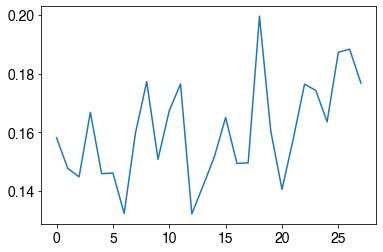

In [54]:
plt.plot(np.nanmean(np.nanmean(np.array([heatwave_days[:,:,i]/growing_season_len for i in range(heatwave_days.shape[2])]), axis=2), axis=1))

In [41]:
lat = era5_mx2t_quantiles.latitude.values
lon = era5_mx2t_quantiles.longitude.values

In [48]:
# regrid sacks data

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)

Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [128]:
heatwave_days = np.full([lat.size, lon.size, len(range(1979, 2018+1))], np.nan)

In [129]:
nnLen = len(np.where(~np.isnan(np.reshape(sacksStart_regrid, [sacksStart_regrid.size, 1])))[0])

In [130]:
# heatwave_days[:, :, y] = curTmax \
#                             .where(curTmax > era5_mx2t_quantiles.mx2t) \
#                             .count(dim='time').values

In [ ]:
for y, year in enumerate(range(1980, 2018+1)):
    print('year %d'%year)
    dsMax = xr.open_dataset('%s/daily/tasmax_%d.nc'%(dirEra5, year))
    dsMax.load()
    dsMax['mx2t'] -= 273.15
    
    dsMaxLast = xr.open_dataset('%s/daily/tasmax_%d.nc'%(dirEra5, year-1))
    dsMaxLast.load()
    dsMaxLast['mx2t'] -= 273.15
    
    n = 0
    
    for xlat in range(len(lat)):

        for ylon in range(len(lon)):

            if ~np.isnan(sacksStart_regrid[xlat, ylon]) and ~np.isnan(sacksEnd_regrid[xlat, ylon]):

                if n % 30000 == 0:
                    print('%.0f %% complete'%(n/(nnLen)*100))

                # in southern hemisphere when planting happens in fall and harvest happens in spring
                if sacksStart_regrid[xlat, ylon] > sacksEnd_regrid[xlat, ylon]:
                    curTmax = xr.concat([dsMaxLast.mx2t[int(sacksStart_regrid[xlat, ylon]):, xlat, ylon], \
                                         dsMax.mx2t[:int(sacksEnd_regrid[xlat, ylon]), xlat, ylon]], dim='time')
                else:
                    curTmax = dsMax.mx2t[int(sacksStart_regrid[xlat, ylon]):int(sacksEnd_regrid[xlat, ylon]), xlat, ylon]

                heatwave_days[xlat, ylon, y] = np.where(curTmax.values > era5_mx2t_quantiles.mx2t[xlat, ylon].values)[0].size
                n += 1


year 1980
0 % complete
9 % complete
18 % complete
26 % complete
35 % complete
44 % complete
53 % complete
61 % complete
70 % complete
79 % complete
88 % complete
96 % complete
year 1981
0 % complete
9 % complete
18 % complete
26 % complete
35 % complete
44 % complete
53 % complete
61 % complete
70 % complete
79 % complete
88 % complete
96 % complete
year 1982
0 % complete
9 % complete
18 % complete
26 % complete
35 % complete
44 % complete
53 % complete
61 % complete
70 % complete
79 % complete
88 % complete
96 % complete
year 1983
0 % complete
9 % complete


In [123]:
np.where(curTmax.values > era5_mx2t_quantiles.mx2t[xlat, ylon].values)[0].size

36

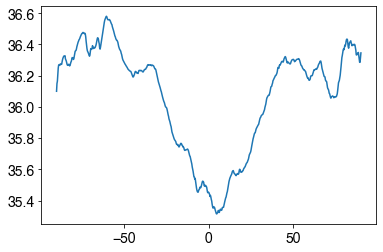

In [31]:
plt.plot(np.linspace(90, -90, heatwave_days.shape[0]), np.nanmean(np.nanmean(heatwave_days, axis=2), axis=1))

In [ ]:
dsMax_quantile = dsMax.quantile(q=0.9, dim='time')
dsMax_quantile.mx2t.to_netcdf('era5_mx2t_q90.nc')

In [11]:
dsMax_quantile_midwest = dsMax_quantile.sel(latitude=slice(45,40), longitude=slice(250,260))

In [ ]:
dsMax_quantile_midwest.mx2t.plot()